## Citibike Daily Trips Predictions

We attempt to predict daily ridership using an ordinary least squares linear regression approach.

Disclaimer: there are issues of multicollinearity and the data itself does not lend well to a linear regression approach

Tutorials Used:
- [Scikit-Learn Linear Regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html)
- [Digital Ocean Classifier](https://www.digitalocean.com/community/tutorials/how-to-build-a-machine-learning-classifier-in-python-with-scikit-learn)

### Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.io import gbq
import os
import sklearn
from IPython.display import display
from math import sqrt
from datetime import datetime
%matplotlib inline

In [2]:
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [3]:
project_id = os.environ['project_id']

### Daily Trips Query

The below query will collect date, aggregate trip, weather, and operating report data. Each row is a date with related information for 1637 days. It is executed using standard SQL syntax on Google BigQuery.

Notes:
- operating report data such as stations and bicycles is monthly (days of a month will have the same values for these fields)
- weather data (temperature, precipitation, and snowfall) will have multicollinearity issues

In [4]:
trips_weather_stations_by_date_query="""
# Get date, trip, weather, reports data; join reports data on month-year concatenation
SELECT trips_and_weather.*, reports.stations, reports.bicycles
FROM
  (
    # Get date, trip, and weather data; join weather data on date
    SELECT trips_by_date.trip_date AS trip_date, EXTRACT(DAYOFWEEK FROM trips_by_date.trip_date) AS day_of_week, 
      EXTRACT(MONTH FROM trips_by_date.trip_date) AS trip_month, EXTRACT(YEAR FROM trips_by_date.trip_date) AS trip_year,
      trips_by_date.num_trip AS num_trip, trips_by_date.avg_trip AS avg_trip, 
      weather.avg_temperature AS temp, weather.precipitation AS prec, weather.snowfall AS snowfall
    FROM
      (
        # Get aggregate trip data grouped by date
        SELECT EXTRACT(DATE FROM starttime) AS trip_date, COUNT(tripduration) AS num_trip, AVG(tripduration) AS avg_trip 
        FROM
          (
            (
              SELECT starttime, tripduration FROM
              `bigquery-public-data.new_york.citibike_trips`
            )
            UNION ALL
            (
              SELECT starttime, tripduration FROM
              `citibike_tripdata.tripdata_2016_10_to_2017_12`
            )
            UNION ALL
            (
              SELECT starttime, tripduration FROM
              `citibike_tripdata.tripdata_jc_2015_09_to_2017_12`
            )
          )
        GROUP BY trip_date ORDER BY trip_date
      ) AS trips_by_date
      
    JOIN `weather.laguardia_20130701_20171231` AS weather
    ON trips_by_date.trip_date = weather.date
  ) AS trips_and_weather
  
JOIN `operating_reports.reports_2013_07_to_2017_12` AS reports
ON CONCAT(CAST(trips_and_weather.trip_month AS STRING), CAST(trips_and_weather.trip_year AS STRING)) 
  = CONCAT(CAST(EXTRACT(MONTH FROM reports.date) AS STRING), CAST(EXTRACT(YEAR FROM reports.date) AS STRING))
"""

trips_weather_stations_by_date = gbq.read_gbq(query=trips_weather_stations_by_date_query, 
                                              dialect ='standard', project_id=project_id)
trips_weather_stations_by_date.head()

Requesting query... ok.
Job ID: 5e99611d-575c-4f67-8fda-ae89b66e37c3
Query running...
Query done.
Cache hit.

Retrieving results...
Got 1637 rows.

Total time taken 1.54 s.
Finished at 2018-04-11 20:33:30.


,trip_date,day_of_week,trip_month,trip_year,num_trip,avg_trip,temp,prec,snowfall,stations,bicycles
0,2013-11-26,3,11,2013,14999,782.459431,36,0.47,0.0,332,5900
1,2013-11-27,4,11,2013,7976,661.534604,48,1.74,0.0,332,5900
2,2013-11-07,5,11,2013,25719,712.190132,58,0.08,0.0,332,5900
3,2013-11-18,2,11,2013,30615,793.150253,60,0.23,0.0,332,5900
4,2013-11-25,2,11,2013,19116,661.051580,28,0.00,0.0,332,5900


In [5]:
trips_weather_stations_by_date.dtypes

trip_date       object
day_of_week      int32
trip_month       int32
trip_year        int32
num_trip         int32
avg_trip       float64
temp             int32
prec           float64
snowfall       float64
stations         int32
bicycles         int32
dtype: object

In the descriptive statistics below, we note a few things. The num_trip field has a standard deviation of 16929.4 daily trips and ranges from 876 to 75,917 daily trips, expressing high variance with ridership. Additionally, the precipitation and snowfall values are typically 0, reflecting no/limited precipitation most of the time. 

In [6]:
trips_weather_stations_by_date.describe()

,day_of_week,trip_month,trip_year,num_trip,avg_trip,temp,prec,snowfall,stations,bicycles
count,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000
mean,4.001222,6.879658,2015.214417,32902.918143,914.586178,57.227856,0.110574,0.084301,448.080024,6707.524130
std,2.001527,3.421608,1.315634,16929.402344,210.753427,17.608727,0.324160,0.607485,131.113953,1909.499756
min,1.000000,1.000000,2013.000000,876.000000,569.723753,8.000000,0.000000,0.000000,319.000000,3457.000000
25%,2.000000,4.000000,2014.000000,20384.000000,780.936392,44.000000,0.000000,0.000000,327.000000,5362.000000
50%,4.000000,7.000000,2015.000000,32203.000000,880.166972,59.000000,0.000000,0.000000,442.000000,6628.000000
75%,6.000000,10.000000,2016.000000,42832.000000,1009.718065,73.000000,0.030000,0.000000,590.000000,8139.000000
max,7.000000,12.000000,2017.000000,75917.000000,4866.605023,92.000000,5.260000,8.100000,740.000000,11367.000000


### Plot of Daily Trips Over Time

Below is a plot of daily trips over time from July 2013 to December 2017. There are noticable trends of general ridership increasing over the years as well as seasonal cycles of peaks during the summer and drops during the winter. These trips may also be affected by holidays and other events, which are not explored in this notebook.

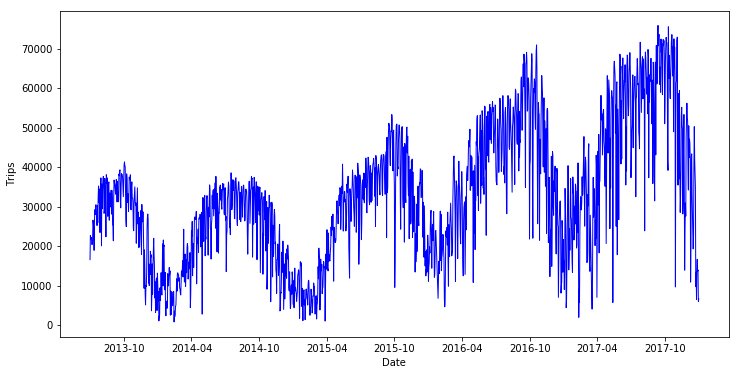

In [7]:
# Alias and sort by trip_date
twsbd = trips_weather_stations_by_date
twsbd = twsbd.sort_values(by=['trip_date'])

plt.figure(figsize=(12,6))

plt.plot(twsbd['trip_date'], twsbd['num_trip'], color='blue', linewidth=1)

plt.xlabel('Date')
plt.ylabel('Trips')

plt.show()

### Weather Scatterplots

Below are scatterplots of daily trips against weather features. 

For temperature, there is heteroskedasticity, as variability in number of trips increases as temperature rises. At the lower end of the spectrum, colder temperatures seem to discourage ridership, while other factors seem to be more influential at higher temperatures. 

For precipitation, no precipitation seems to be the normal case with varying daily trips. At higher levels of precipitation, daily trips seem to decrease.

Snowfall is similar to precipitation, but with a more pronounced drop in ridership with any presence of snow.

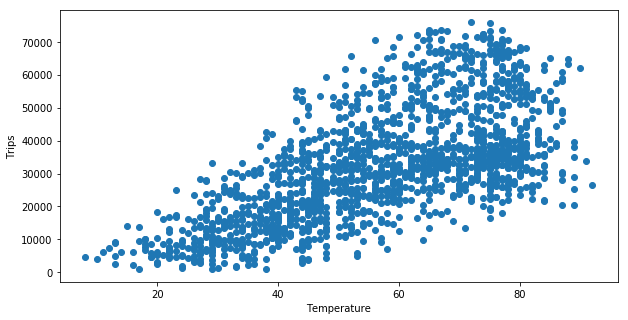

In [8]:
plt.figure(figsize=(10,5))

plt.scatter(twsbd['temp'], twsbd['num_trip'])

plt.xlabel('Temperature')
plt.ylabel('Trips')

plt.show()

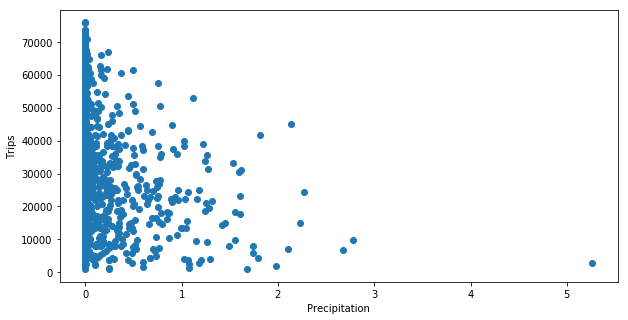

In [9]:
plt.figure(figsize=(10,5))

plt.scatter(twsbd['prec'], twsbd['num_trip'])

plt.xlabel('Precipitation')
plt.ylabel('Trips')

plt.show()

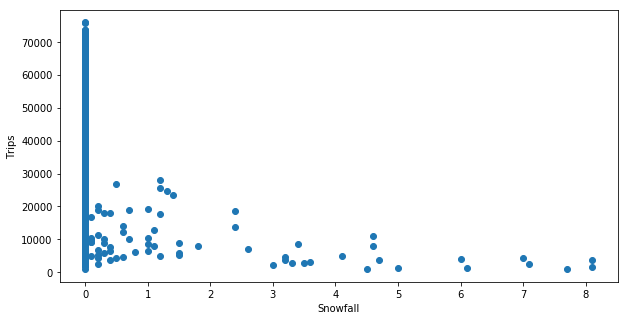

In [10]:
plt.figure(figsize=(10,5))

plt.scatter(twsbd['snowfall'], twsbd['num_trip'])

plt.xlabel('Snowfall')
plt.ylabel('Trips')

plt.show()

### Cyclical Features

Daily trip numbers are affected by the cyclical trends such as the day of the week and month. These features help to capture factors such as the work week and schools being out of session.

Since the trip_month and day_of_week variables are on the scale of 1 to 12 and 1 to 7 respectively, our model will not naturally recognize the "closeness" of certain values. For instance, December (12) and January (1) will be seen as far apart numerically. In turn, we create sin and cos features for both trip_month and day_of_week variables to compensate for this. 

References:
- [Encoding Cyclical Features](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/)
- [Feature Engineering](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html)

In [11]:
twsbd['month_sin'] = np.sin((twsbd['trip_month'] - 1) * (2.0 * np.pi/12))
twsbd['month_cos'] = np.cos((twsbd['trip_month'] - 1) * (2.0 * np.pi/12))

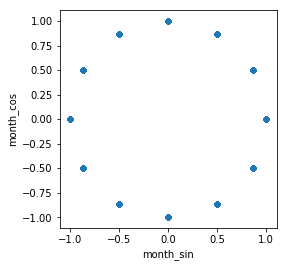

In [12]:
twsbd.plot.scatter('month_sin','month_cos').set_aspect('equal');

In [13]:
twsbd['day_of_week_sin'] = np.sin((twsbd['day_of_week'] - 1) * (2.0 * np.pi/7))
twsbd['day_of_week_cos'] = np.cos((twsbd['day_of_week'] - 1) * (2.0 * np.pi/7))

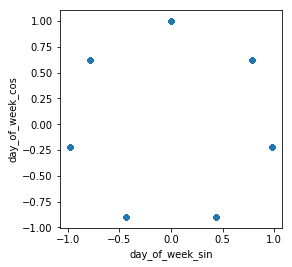

In [14]:
twsbd.plot.scatter('day_of_week_sin','day_of_week_cos').set_aspect('equal');

### Preparing our Model

We will utilize a linear model to predict the number of trips (label or y variable) given date, weather, and stations data (features or x variables).

We will take our 1637 rows of data and split them into training and testing sets. Our training set will be 67% of our data and the testing set will be the remaining 33%. We seed the number generator with random_state 42 to guarantee the same output for experimentation purposes. 

- train > training set values for our 8 features 
- test > testing set values for our 8 features
- train_labels > training set values for our label (num_trip)
- test_labels > testing set values for our label (num_trip)

In [15]:
# Organize our data
labels = twsbd['num_trip']
features = twsbd[['trip_date', 'temp', 'prec', 'snowfall', 'day_of_week_sin', 
                  'day_of_week_cos', 'month_sin', 'month_cos', 'stations']]
# Actual features will exclude trip_date, trip_date used later for visualizations

In [16]:
features.shape

(1637, 9)

In [17]:
train_preprocess, test_preprocess, train_labels, test_labels = train_test_split(features, labels, 
                                                                                test_size=0.33, random_state=42)
train = train_preprocess.drop(columns=['trip_date'])
test = test_preprocess.drop(columns=['trip_date'])
print('Train Shape:', train.shape, '\nTest Shape:', test.shape)

Train Shape: (1096, 8) 
Test Shape: (541, 8)


### Feature Scaling

As a data preprocessing step, we scale the values of our features since the ranges of these values can vary widely. Below are histograms of features we plan to scale. Since these features do not have normal distributions, we decide to normalize their values into a (0,1) range (as opposed to standardizing them). 

Reference:
- [Normalize and Standardize](https://machinelearningmastery.com/normalize-standardize-time-series-data-python/)

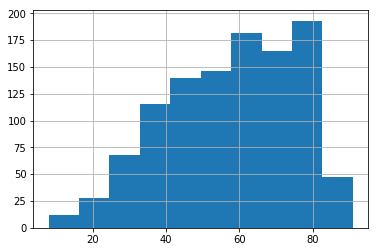

In [18]:
train['temp'].hist()

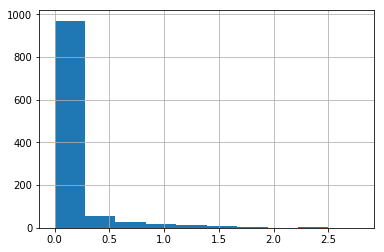

In [19]:
train['prec'].hist()

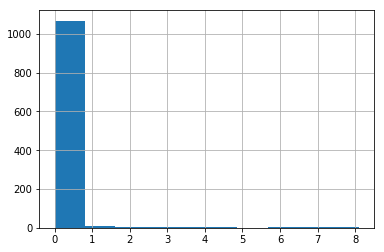

In [20]:
train['snowfall'].hist()

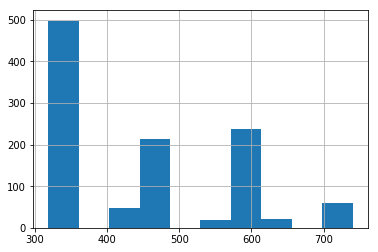

In [21]:
train['stations'].hist()

### Normalizing Data

Below is a function definition for normalizing a field. We use scikit-learn's MinMaxScaler and fit the scaler only to field's values in the training set. This scaler object will be used to scale the training and testing set values to the range of (0,1). The old field will be replaced with the new normalized field. 

In [22]:
def normalize_field(train, test, field):
    
    # Training set field values to be normalized 
    train_values = train[field].values
    train_values = train_values.reshape((len(train_values), 1))  # reshape values into a column of rows

    # Create scaler object and normalize training set values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train_values)
    train[field + '_normalized'] = scaler.transform(train_values)

    display('Min:', scaler.data_min_, 'Max:', scaler.data_max_)
    
    # Testing set field values to be normalized 
    test_values = test[field].values
    test_values = test_values.reshape((len(test_values), 1))  # reshape values into a column of rows

    # Apply scaler fitted to training set values to testing values
    test[field + '_normalized'] = scaler.transform(test_values)
    
    # Drop old field from training and testing sets 
    train = train.drop(columns=[field])
    test = test.drop(columns=[field])
    
    display(train.head())
    display(test.head())
    
    # returns local copies of train and test to ensure that the given field was dropped properly, see link below
    # https://stackoverflow.com/questions/38895768/python-pandas-dataframe-is-it-pass-by-value-or-pass-by-reference
    return train, test

In [23]:
train, test = normalize_field(train, test, 'temp')

C:\Users\Chris\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


'Min:'

array([8.])

'Max:'

array([91.])

,prec,snowfall,day_of_week_sin,day_of_week_cos,month_sin,month_cos,stations,temp_normalized
1338,1.22,0.0,0.781831,0.623490,5.000000e-01,-0.866025,608,0.843373
190,0.00,0.0,0.781831,0.623490,8.660254e-01,-0.500000,327,0.602410
452,0.00,0.0,-0.433884,-0.900969,-8.660254e-01,-0.500000,325,0.843373
239,0.00,0.0,0.000000,1.000000,1.224647e-16,-1.000000,323,0.843373
869,0.00,0.0,0.000000,1.000000,8.660254e-01,-0.500000,319,0.698795


,prec,snowfall,day_of_week_sin,day_of_week_cos,month_sin,month_cos,stations,temp_normalized
879,0.01,0.0,-0.781831,0.623490,0.866025,-0.500000,319,0.602410
1406,0.00,0.0,0.974928,-0.222521,-0.866025,0.500000,729,0.421687
988,0.00,0.0,0.974928,-0.222521,0.866025,0.500000,469,0.481928
649,0.00,0.0,-0.781831,0.623490,0.500000,0.866025,328,0.168675
1493,0.00,0.0,0.781831,0.623490,0.866025,-0.500000,605,0.578313


In [24]:
train, test = normalize_field(train, test, 'prec')

'Min:'

array([0.])

'Max:'

array([2.78])

,snowfall,day_of_week_sin,day_of_week_cos,month_sin,month_cos,stations,temp_normalized,prec_normalized
1338,0.0,0.781831,0.623490,5.000000e-01,-0.866025,608,0.843373,0.438849
190,0.0,0.781831,0.623490,8.660254e-01,-0.500000,327,0.602410,0.000000
452,0.0,-0.433884,-0.900969,-8.660254e-01,-0.500000,325,0.843373,0.000000
239,0.0,0.000000,1.000000,1.224647e-16,-1.000000,323,0.843373,0.000000
869,0.0,0.000000,1.000000,8.660254e-01,-0.500000,319,0.698795,0.000000


,snowfall,day_of_week_sin,day_of_week_cos,month_sin,month_cos,stations,temp_normalized,prec_normalized
879,0.0,-0.781831,0.623490,0.866025,-0.500000,319,0.602410,0.003597
1406,0.0,0.974928,-0.222521,-0.866025,0.500000,729,0.421687,0.000000
988,0.0,0.974928,-0.222521,0.866025,0.500000,469,0.481928,0.000000
649,0.0,-0.781831,0.623490,0.500000,0.866025,328,0.168675,0.000000
1493,0.0,0.781831,0.623490,0.866025,-0.500000,605,0.578313,0.000000


In [25]:
train, test = normalize_field(train, test, 'snowfall')

'Min:'

array([0.])

'Max:'

array([8.1])

,day_of_week_sin,day_of_week_cos,month_sin,month_cos,stations,temp_normalized,prec_normalized,snowfall_normalized
1338,0.781831,0.623490,5.000000e-01,-0.866025,608,0.843373,0.438849,0.0
190,0.781831,0.623490,8.660254e-01,-0.500000,327,0.602410,0.000000,0.0
452,-0.433884,-0.900969,-8.660254e-01,-0.500000,325,0.843373,0.000000,0.0
239,0.000000,1.000000,1.224647e-16,-1.000000,323,0.843373,0.000000,0.0
869,0.000000,1.000000,8.660254e-01,-0.500000,319,0.698795,0.000000,0.0


,day_of_week_sin,day_of_week_cos,month_sin,month_cos,stations,temp_normalized,prec_normalized,snowfall_normalized
879,-0.781831,0.623490,0.866025,-0.500000,319,0.602410,0.003597,0.0
1406,0.974928,-0.222521,-0.866025,0.500000,729,0.421687,0.000000,0.0
988,0.974928,-0.222521,0.866025,0.500000,469,0.481928,0.000000,0.0
649,-0.781831,0.623490,0.500000,0.866025,328,0.168675,0.000000,0.0
1493,0.781831,0.623490,0.866025,-0.500000,605,0.578313,0.000000,0.0


In [26]:
train, test = normalize_field(train, test, 'stations')

C:\Users\Chris\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


'Min:'

array([319.])

'Max:'

array([740.])

,day_of_week_sin,day_of_week_cos,month_sin,month_cos,temp_normalized,prec_normalized,snowfall_normalized,stations_normalized
1338,0.781831,0.623490,5.000000e-01,-0.866025,0.843373,0.438849,0.0,0.686461
190,0.781831,0.623490,8.660254e-01,-0.500000,0.602410,0.000000,0.0,0.019002
452,-0.433884,-0.900969,-8.660254e-01,-0.500000,0.843373,0.000000,0.0,0.014252
239,0.000000,1.000000,1.224647e-16,-1.000000,0.843373,0.000000,0.0,0.009501
869,0.000000,1.000000,8.660254e-01,-0.500000,0.698795,0.000000,0.0,0.000000


,day_of_week_sin,day_of_week_cos,month_sin,month_cos,temp_normalized,prec_normalized,snowfall_normalized,stations_normalized
879,-0.781831,0.623490,0.866025,-0.500000,0.602410,0.003597,0.0,0.000000
1406,0.974928,-0.222521,-0.866025,0.500000,0.421687,0.000000,0.0,0.973872
988,0.974928,-0.222521,0.866025,0.500000,0.481928,0.000000,0.0,0.356295
649,-0.781831,0.623490,0.500000,0.866025,0.168675,0.000000,0.0,0.021378
1493,0.781831,0.623490,0.866025,-0.500000,0.578313,0.000000,0.0,0.679335


### Linear Regression Model

We create a linear regression model and train it using the training set. Afterwards, we use the model to generate predictions based on the testing set's features.

In [27]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [28]:
# Make predictions
predictions = regr.predict(test)
predictions.shape

(541,)

### Model Metrics

#### Model:

```
num_trip = 1689.8(day_of_week_sin) - 4605.8(day_of_week_cos) - 1232.4(month_sin) 
            - 4678.1(month_cos) + 33810.8(temp_normalized) - 37984.5(prec_normalized) 
            - 1789.2(snowfall_normalized) + 30495.4(stations_normalized)
```

The root mean squared error (RMSE) represents the sample standard deviation of differences between our predictions and actual values. For a normal distribution, about 68% of the differences (residuals) should be within the range of -RMSE to RMSE. Although this may not be the exact case for our model due to the nature of our data, it expresses that the majority of our predictions will fall within the range of +/- 7776.5 trips. 

The R-squared value is the percentage of the variability in the data that our model explains. 79% of the variability is explained through our model, but there may be severe multicollinearity.

In [29]:
# Model Coefficients
print('Coefficients: \n', regr.coef_)
# Mean squared error
print("Mean squared error: %.2f" % mean_squared_error(test_labels, predictions))
# Root mean squared error
print("Root mean squared error: %.2f" % sqrt(mean_squared_error(test_labels, predictions)))
# Explained variance score
print('Variance score: %.2f' % r2_score(test_labels, predictions))

Coefficients: 
 [  1689.7865232   -4605.82654167  -1232.37560677  -4678.07331017
  33810.75936168 -37984.5432101   -1789.18151535  30495.38133222]
Mean squared error: 60474234.57
Root mean squared error: 7776.52
Variance score: 0.79


### Plot Actual Trips vs Predictions

Below is a plot of actual trips against our model's predictions. The values seem to hover around the diagonal line, suggesting that the model generally makes adequate predictions.

Note: since the model is a linear model, there are a couple negative prediction values not shown in this plot

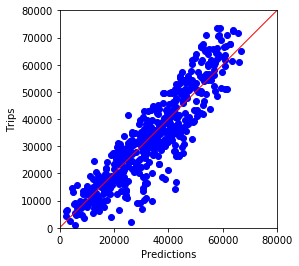

In [31]:
# Plot test_labels against predictions
plt.scatter(predictions, test_labels, color='blue')
plt.plot([0, 80000], [0, 80000], color='red', linestyle='-', linewidth=1)

plt.xlabel('Predictions')
plt.ylabel('Trips')

# Set box
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

A subset of the twsbd dataframe is made based on the values of the testing set. 

In [32]:
test_df = twsbd.loc[twsbd['trip_date'].isin(test_preprocess['trip_date'])]
test_df.shape

(541, 15)

In [33]:
test_df.head()

,trip_date,day_of_week,trip_month,trip_year,num_trip,avg_trip,temp,prec,snowfall,stations,bicycles,month_sin,month_cos,day_of_week_sin,day_of_week_cos
142,2013-07-16,3,7,2013,29842,907.713055,87,0.0,0.0,328,5531,1.224647e-16,-1.0,0.974928,-0.222521
146,2013-07-19,6,7,2013,26591,880.263172,92,0.0,0.0,328,5531,1.224647e-16,-1.0,-0.974928,-0.222521
132,2013-07-24,4,7,2013,35271,935.532165,80,0.0,0.0,328,5531,1.224647e-16,-1.0,0.433884,-0.900969
128,2013-07-30,3,7,2013,37334,949.690791,76,0.0,0.0,328,5531,1.224647e-16,-1.0,0.974928,-0.222521
129,2013-07-31,4,7,2013,37261,923.552830,76,0.0,0.0,328,5531,1.224647e-16,-1.0,0.433884,-0.900969


Merge predictions to the dataframe and add residuals for plotting.

In [34]:
# Add predictions to test dataframe
predictions_df = pd.DataFrame(predictions, columns=['predictions'])
test_df = test_df.merge(predictions_df, left_index=True, right_index=True)

# Add residuals to test dataframe
test_df['residuals'] = test_df['predictions'] - test_df['num_trip']

# Sort by trip_date
test_df = test_df.sort_values(by=['trip_date'])
test_df.head()

,trip_date,day_of_week,trip_month,trip_year,num_trip,avg_trip,temp,prec,snowfall,stations,bicycles,month_sin,month_cos,day_of_week_sin,day_of_week_cos,predictions,residuals
142,2013-07-16,3,7,2013,29842,907.713055,87,0.0,0.0,328,5531,1.224647e-16,-1.0,0.974928,-0.222521,29294.635935,-547.364065
146,2013-07-19,6,7,2013,26591,880.263172,92,0.0,0.0,328,5531,1.224647e-16,-1.0,-0.974928,-0.222521,22763.066870,-3827.933130
132,2013-07-24,4,7,2013,35271,935.532165,80,0.0,0.0,328,5531,1.224647e-16,-1.0,0.433884,-0.900969,32229.301474,-3041.698526
128,2013-07-30,3,7,2013,37334,949.690791,76,0.0,0.0,328,5531,1.224647e-16,-1.0,0.974928,-0.222521,47221.218428,9887.218428
129,2013-07-31,4,7,2013,37261,923.552830,76,0.0,0.0,328,5531,1.224647e-16,-1.0,0.433884,-0.900969,29727.135992,-7533.864008


### Subplots of Actual Values vs. Predictions and Residuals Over Time

Below are 2 subplots that display the actual daily trips with prediction values as well as residuals. The subplots share the same x-axis of trip_date. There are a couple negative values for predictions. It is interesting to note that actual daily values seems to follow a smooth trend while the predictions seems to vary widely.

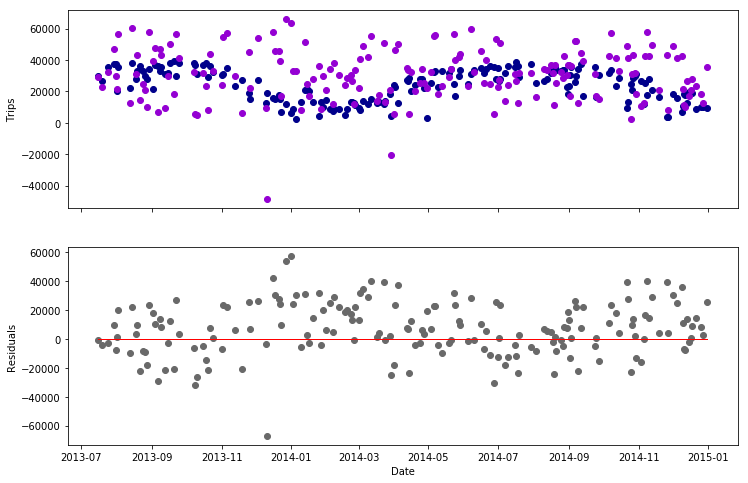

In [35]:
# Plot 2 subplots sharing x axis
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,8))

# Subplot of num_trip and predictions
ax1.plot_date(test_df['trip_date'], test_df['num_trip'], color='darkblue')
ax1.plot_date(test_df['trip_date'], test_df['predictions'], color='darkviolet')

ax1.set(ylabel='Trips')

# Subplot of residuals
ax2.plot_date(test_df['trip_date'], test_df['residuals'], color='dimgray')

xmin = min(test_df['trip_date'])
xmax = max(test_df['trip_date'])
ax2.plot([xmin, xmax], [0, 0], color='red', linestyle='-', linewidth=1)

ax2.set(xlabel='Date')
ax2.set(ylabel='Residuals')

plt.show()

### Residual Plot

Below is a plot of the residuals against the daily trips. The residuals seem to be consistently scattered at varying values for num_trip, suggesting a linear model was a good fit for the data.

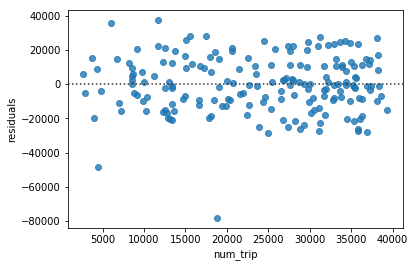

In [36]:
sns.residplot(x='num_trip', y='residuals', data=test_df)